# NHL Data Analysis
  "If you have time can you put like an intro here? Doesnt have to be long"
### Research Questions
    - Which NHL Teams have been statistcally the most dominate compared to achieved results
    - For each NHL Team, who has had the most "Successful Tenure"
    - "Vanessa fill in"
---
Please view both of our EDA's beforehand for a little more context and understanding of what will be doing!

### Loading Preliminary functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
##import pandas_profiling
##from pandas_profiling import ProfileReport
import sys
sys.path.append('..')
from scripts import ProjectFunctions as pf

### Importing Data Lists
The next line we are just importing the data from our local repositorys, this can be changed to a url or any other method for replicaton
- The [NHL DATA is from this Kaggle page.](https://www.kaggle.com/martinellis/nhl-game-data) for convienance

All data is provided and can be sourced from the NHL’s API, unofficial documentation can be found on Drew Hynes’ gitlab here: https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md

In [2]:
k = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game_teams_stats.csv"
l = "C:/Users/keati/Documents/Cosc301/Nhl_Data/team_info.csv"
z = "C:/Users/keati/Documents/Cosc301/Nhl_Data/game.csv"

df1 = pf.CoachData(k)
df2 = pf.TeamData(k)
df3 = pf.TeamList(l)
## df4 name is taken - go df5 and up :)


Coach_df = pd.merge(df3,df1, how='inner')
total_df = pd.concat([df3,df2],axis=1).reindex(df2.index)

## Successful Tenure

To start off our analysis of the most dominate team I first wanted to look at each individual team and figure out who on which coach has had the best run on each team

In [3]:
step1 = pd.merge(pd.read_csv(k),pd.read_csv(z), how='inner')
step2 = step1.groupby(['head_coach','team_id']).sum().reset_index().drop(['game_id', 'home_team_id','season','away_team_id','venue_time_zone_offset','goals'], axis = 'columns')
df4 = pd.merge(df3,step2, how='inner')
Total = df4.sort_values('won').drop_duplicates('teamName', keep = 'last').reset_index(drop=True)
Total

,team_id,shortName,teamName,head_coach,won,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,away_goals,home_goals
0,11,Atlanta,Thrashers,Bob Hartley,136,8247.0,4847.0,4638.0,1548.0,260.0,0.0,3076.0,2355.0,3865.0,849,926
1,9,Ottawa,Senators,Jacques Martin,181,9763.0,2606.0,4768.0,1464.0,288.0,0.0,1323.0,822.0,1168.0,871,944
2,13,Florida,Panthers,Bob Boughner,188,13643.0,9257.0,3651.0,1325.0,335.0,20527.1,6012.0,3742.0,5724.0,1229,1453
3,4,Philadelphia,Flyers,Alain Vigneault,204,10396.0,8172.0,2772.0,1112.0,204.0,18622.4,3484.0,2116.0,4412.0,920,1104
4,20,Calgary,Flames,Bill Peters,248,14696.0,7564.0,4188.0,1532.0,288.0,23629.2,6216.0,4524.0,5868.0,1288,1488
5,26,Los Angeles,Kings,Darryl Sutter,267,15271.0,15689.0,5011.0,1578.0,289.0,25386.1,4715.0,2228.0,6080.0,1155,1290
6,25,Dallas,Stars,Dave Tippett,271,13851.0,9354.0,7258.0,2285.0,399.0,0.0,5651.0,3729.0,5018.0,1232,1393
7,1,New Jersey,Devils,John Hynes,271,20206.0,15229.0,6375.0,2182.0,384.0,33077.4,5754.0,4836.0,9250.0,1829,2152
8,3,NY Rangers,Rangers,David Quinn,276,18546.0,14964.0,6673.0,1851.0,388.0,28891.6,7730.0,5007.0,9183.0,1846,2019
9,22,Edmonton,Oilers,Craig MacTavish,301,18263.0,6856.0,9936.0,3026.0,469.0,232.6,6417.0,3362.0,6174.0,1759,1933


- From this dataframe I was able to plot and see which had the most amount of wins with each individual team

Text(0.5, 1.0, 'Most Wins for each Team')

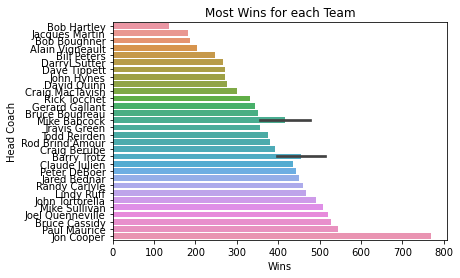

In [4]:
Most_wins = Total.sort_values('won').drop_duplicates('teamName', keep = 'last').reset_index(drop=True)
sns.barplot(x='won',y='head_coach',data=Most_wins,linewidth=1)
plt.xlabel("Wins")
plt.ylabel("Head Coach")
plt.title("Most Wins for each Team")

Moving on from this base Information I wanted to see what made each coach with there respective made them so successful.

To achieve this I created another two columns figuring out the each teams total goal percentage and power play goal percentage

In [5]:
Total['Total Goals'] = Total['away_goals'] + Total['home_goals']

In [6]:
Total['Goal Percentage in %'] = (((Total['away_goals'] + Total['home_goals'])/Total['shots'])*100)
Total['PPG Goal Percentage in %'] = ((Total['powerPlayGoals']/Total['powerPlayOpportunities'])*100)
Total.head()

,team_id,shortName,teamName,head_coach,won,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,away_goals,home_goals,Total Goals,Goal Percentage in %,PPG Goal Percentage in %
0,11,Atlanta,Thrashers,Bob Hartley,136,8247.0,4847.0,4638.0,1548.0,260.0,0.0,3076.0,2355.0,3865.0,849,926,1775,21.522978,16.795866
1,9,Ottawa,Senators,Jacques Martin,181,9763.0,2606.0,4768.0,1464.0,288.0,0.0,1323.0,822.0,1168.0,871,944,1815,18.590597,19.672131
2,13,Florida,Panthers,Bob Boughner,188,13643.0,9257.0,3651.0,1325.0,335.0,20527.1,6012.0,3742.0,5724.0,1229,1453,2682,19.658433,25.283019
3,4,Philadelphia,Flyers,Alain Vigneault,204,10396.0,8172.0,2772.0,1112.0,204.0,18622.4,3484.0,2116.0,4412.0,920,1104,2024,19.469027,18.345324
4,20,Calgary,Flames,Bill Peters,248,14696.0,7564.0,4188.0,1532.0,288.0,23629.2,6216.0,4524.0,5868.0,1288,1488,2776,18.889494,18.798956


<AxesSubplot:xlabel='Goal Percentage in %', ylabel='head_coach'>

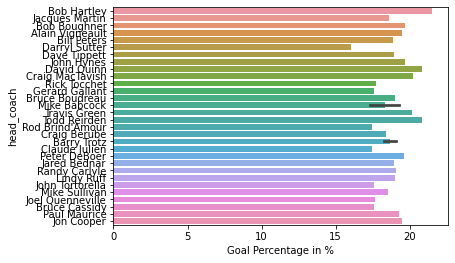

In [7]:
sns.barplot(x='Goal Percentage in %',y='head_coach',data=Total,linewidth=0.2)

<AxesSubplot:xlabel='PPG Goal Percentage in %', ylabel='head_coach'>

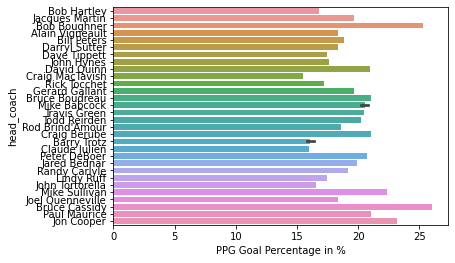

In [8]:
sns.barplot(x='PPG Goal Percentage in %',y='head_coach',data=Total,linewidth=0.2)

## Most dominate

To talk about most dominate, We will be exploring the stats from each team regardless off there overall achieved results in the last 8 years

From this we are able to see which teams have been able to win the most games with the bruins almost doubling the Jets. We also must acknlowedge the data may be a bit flawed from this perspective as the Golden Knights have not been in the league as long as every other team.

In [ ]:
total_df.head()

In [ ]:
pd_df = total_df.sort_values(['won']).reset_index(drop=True)
sns.barplot(x='won',y='teamName',data=pd_df,linewidth=1)

To work around this I am going to create a weighted total including shots, hits, takeaways and blocked shots as these stats are more relative to the overal play of a team rather than goals.
The scores will be computed with:
 - 40% Shots - Help a team win  with offense
 - 30% takeaway - Generates a turn over and gives the team the play
 - 10% Hits - defensive statistic, defending your zone
 - 20% block shots - defensive statistic
 
 

In [ ]:
total_df['Weighted Score'] = (0.4*df2['shots'] + 0.3*df2['takeaways'] + 0.1*df2['hits'] + 0.2*df2['blocked'])
Sample = pd.DataFrame(total_df.groupby("teamName")['Weighted Score'].mean().sort_values(ascending=False).reset_index())
Sample

This produces an interesting result. You can see that Bruins are the top when it comes to the weighted total, however, the wild are near the bottom however only finishing middle of the pack in wins

## Vanessa Research Question